#### Imports

In [1168]:
# Imports 
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error

In [1169]:
df = pd.read_csv('Data/clean_stats.csv', index_col=0)

In [1170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14925 entries, 0 to 14924
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               14925 non-null  object 
 1   Team               14925 non-null  object 
 2   Week               14925 non-null  int64  
 3   Opponent           14925 non-null  object 
 4   Points_Scored      14925 non-null  float64
 5   Position           14925 non-null  object 
 6   OPRNK              14909 non-null  float64
 7   Projected          14912 non-null  float64
 8   Salary             14925 non-null  int64  
 9   Games_Played       14925 non-null  int64  
 10  FPPG               14782 non-null  float64
 11  Date               14925 non-null  int64  
 12  Line Close         14925 non-null  float64
 13  Total Score Close  14925 non-null  float64
 14  Team Proj          14925 non-null  float64
 15  Home / Away        14925 non-null  object 
dtypes: float64(7), int64(4

In [1171]:
df = df[df['Week'] != 17]

In [1172]:
df = df[df['Position'] != 'K']

In [1173]:
df = df[df['Position'] != 'LB']

#### Ordinal Encoding Home / Away

In [1174]:
from sklearn.preprocessing import OrdinalEncoder
home = df[['Home / Away']]
encoder_home = OrdinalEncoder()
encoder_home.fit(home)
home_encoded = encoder_home.transform(home)
home_encoded = home_encoded.flatten()
df['Home / Away'] = home_encoded

In [1175]:
df = df.dropna()

In [1176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13911 entries, 0 to 14924
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               13911 non-null  object 
 1   Team               13911 non-null  object 
 2   Week               13911 non-null  int64  
 3   Opponent           13911 non-null  object 
 4   Points_Scored      13911 non-null  float64
 5   Position           13911 non-null  object 
 6   OPRNK              13911 non-null  float64
 7   Projected          13911 non-null  float64
 8   Salary             13911 non-null  int64  
 9   Games_Played       13911 non-null  int64  
 10  FPPG               13911 non-null  float64
 11  Date               13911 non-null  int64  
 12  Line Close         13911 non-null  float64
 13  Total Score Close  13911 non-null  float64
 14  Team Proj          13911 non-null  float64
 15  Home / Away        13911 non-null  float64
dtypes: float64(8), int64(4

In [1177]:
categoricals = ['Team', 'Name', 'Week', 'Opponent', 'Position', 'Date']
df_no_cats = df.drop(categoricals, axis=1)

In [1178]:
df_no_cats['Points'] = df_no_cats['Points_Scored']

In [1179]:
df_no_cats = df_no_cats.drop('Points_Scored', axis=1)

In [1180]:
df_no_cats = df_no_cats.rename(columns={'Line Close':'line_close', 'Total Score Close':'over_under'})
df_no_cats = df_no_cats.rename(columns={'Team Proj':'team_proj', 'Home / Away':'home_away'})

In [1181]:
multiple_formula = 'Points ~ Projected'
multiple_model = ols(multiple_formula, df_no_cats).fit()
multiple_model_summary = multiple_model.summary()
multiple_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Points   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                 1.478e+04
Date:                Sat, 18 Sep 2021   Prob (F-statistic):               0.00
Time:                        12:39:21   Log-Likelihood:                -42682.
No. Observations:               13911   AIC:                         8.537e+04
Df Residuals:                   13909   BIC:                         8.538e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2227      0.066      3.394      0.001       0.094       0.351
Projected      0.9777      0.008    121.587      0.000       0.962       0.993
==============================================================================
Omnibus:                     3405.782   Durbin-Watson:                   1.504
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11332.084
Skew:                           1.228   Prob(JB):                         0.00
Kurtosis:                       6.676   Cond. No.                         12.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1182]:
correlation_matrix = df_no_cats.corr()

In [1183]:
df_corr=correlation_matrix.abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head(10)

,cc
pairs,
"(team_proj, line_close)",0.943265
"(Salary, Projected)",0.911144
"(FPPG, Projected)",0.898109
"(Salary, FPPG)",0.865007
"(Projected, Points)",0.717800
"(FPPG, Points)",0.669229
"(Salary, Points)",0.662948
"(team_proj, over_under)",0.327088
"(line_close, home_away)",0.309246


In [1184]:
pf = PolynomialFeatures(degree=2)

X = df_no_cats


pf.fit(X)
pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names())
pdf
corr_df = pdf.corr()
corr_df[corr_df['x9'] > .7]['x9']

x1       0.717800
x9       1.000000
x0 x9    0.820990
x1 x2    0.707655
x1 x6    0.712007
x1 x9    0.901616
x2 x9    0.974289
x3 x9    0.806577
x4 x9    0.857341
x6 x9    0.991805
x7 x9    0.944922
x9^2     0.918247
Name: x9, dtype: float64

#### OneHotEncoding Categoricals

In [1185]:
df['Position'].value_counts()

WR    5270
RB    3938
TE    3286
QB    1417
Name: Position, dtype: int64

In [1186]:
X = df.copy()

from sklearn.preprocessing import OneHotEncoder
position = X[['Position']]
ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(position)
ohe.categories_
position_encoded = ohe.transform(position)

position_encoded = pd.DataFrame(

    position_encoded,

    columns=ohe.categories_[0],
 
    index=X.index
)

position_encoded

,QB,RB,TE,WR
0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
14920,0.0,0.0,0.0,1.0
14921,0.0,0.0,0.0,1.0
14922,0.0,0.0,1.0,0.0
14923,0.0,0.0,1.0,0.0


In [1187]:
X = df.copy()

year = X[['Date']]
ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(year)
ohe.categories_
year_encoded = ohe.transform(year)

year_encoded = pd.DataFrame(

    year_encoded,

    columns=ohe.categories_[0],
 
    index=X.index
)

year_encoded.drop(2019, axis=1)

,2017,2018
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
14920,0.0,0.0
14921,0.0,0.0
14922,0.0,0.0
14923,0.0,0.0


In [1188]:
from sklearn.linear_model import LinearRegression
y = df['Points_Scored']
X = df_no_cats[['OPRNK', 'Projected', 'FPPG', 'home_away', 'team_proj', 'Salary']]

model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.5189364177477487

In [1189]:
X = pd.concat([X.reset_index(drop=True), position_encoded.reset_index(drop=True)], axis=1)

In [1190]:
# X = pd.concat([X.reset_index(drop=True), year_encoded.reset_index(drop=True)], axis=1)

In [1191]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.5198103156219266

In [1192]:
X['QB_proj'] = X['QB'] * X['Projected'] * X['OPRNK']

In [1193]:
X['RB_proj'] = X['RB'] * X['Projected'] * X['OPRNK']

In [1194]:
X['WR_proj'] = X['WR'] * X['Projected'] * X['OPRNK']

In [1195]:
X['TE_proj'] = X['TE'] * X['Projected'] * X['OPRNK']

In [1196]:
model = LinearRegression()
model.fit(X, y)
model.score(X,y)

0.5201720721040957

In [1197]:
preds = model.predict(X)

In [1198]:
mean_squared_error(df['Points_Scored'], preds)

26.797269164409414

In [1199]:
mean_squared_error(df['Points_Scored'], df['Projected'])

27.095572791316222

In [1200]:
residual = y - model.predict(X)

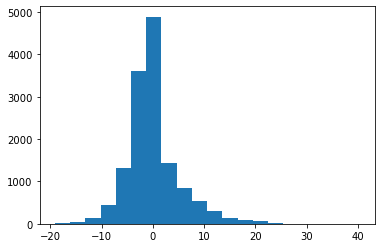

In [1201]:
fig, ax = plt.subplots()
ax.hist(residual, bins=20);

In [1202]:
df['residual'] = residual

In [1203]:
df['prediction'] = model.predict(X)

In [1204]:
pos_residuals = df.sort_values(by='residual', ascending=False)

In [1205]:
pos_residuals

,Name,Team,Week,Opponent,Points_Scored,Position,OPRNK,Projected,Salary,Games_Played,FPPG,Date,Line Close,Total Score Close,Team Proj,Home / Away,residual,prediction
9840,Derrick Henry,TEN,14,JAX,47.80,RB,2.0,7.42,5500,13,7.5,2018,-5.5,37.0,24.00,1.0,40.293055,7.506945
12410,Aaron Jones,GB,5,DAL,45.70,RB,7.0,14.06,6800,5,14.2,2019,3.0,46.5,20.25,0.0,32.199555,13.500445
9851,Amari Cooper,DAL,14,PHI,44.70,WR,28.0,13.07,6900,12,10.8,2018,-3.5,45.0,26.00,1.0,32.117940,12.582060
11022,Sammy Watkins,KC,1,JAX,42.30,WR,1.0,9.62,6300,1,18.8,2019,-3.5,49.0,28.00,0.0,31.741308,10.558692
3124,Julio Jones,ATL,12,TB,44.80,WR,31.0,13.86,7800,9,10.0,2017,-10.5,47.0,34.00,1.0,31.550239,13.249761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9096,Carson Wentz,PHI,11,NO,3.84,QB,32.0,21.25,7700,8,20.5,2018,7.5,56.5,20.75,0.0,-17.677979,21.517979
13318,Matt Ryan,ATL,7,LAR,3.56,QB,13.0,20.66,7900,7,24.3,2019,3.0,54.5,24.25,1.0,-17.678760,21.238760
11681,Christian McCaffrey,CAR,2,TB,6.30,RB,12.0,22.17,9200,2,37.9,2019,-6.5,48.0,30.50,1.0,-17.923048,24.223048
1938,Aaron Rodgers,GB,6,MIN,0.72,QB,7.0,19.60,9000,5,21.2,2017,-3.0,46.0,26.00,0.0,-18.807944,19.527944


In [1206]:
neg_residuals = df.sort_values(by='residual', ascending=True)

In [1207]:
neg_residuals

,Name,Team,Week,Opponent,Points_Scored,Position,OPRNK,Projected,Salary,Games_Played,FPPG,Date,Line Close,Total Score Close,Team Proj,Home / Away,residual,prediction
381,Andy Dalton,CIN,1,BAL,-3.00,QB,9.0,16.99,7400,1,10.3,2017,-2.5,41.5,23.25,1.0,-19.088725,16.088725
1938,Aaron Rodgers,GB,6,MIN,0.72,QB,7.0,19.60,9000,5,21.2,2017,-3.0,46.0,26.00,0.0,-18.807944,19.527944
11681,Christian McCaffrey,CAR,2,TB,6.30,RB,12.0,22.17,9200,2,37.9,2019,-6.5,48.0,30.50,1.0,-17.923048,24.223048
13318,Matt Ryan,ATL,7,LAR,3.56,QB,13.0,20.66,7900,7,24.3,2019,3.0,54.5,24.25,1.0,-17.678760,21.238760
9096,Carson Wentz,PHI,11,NO,3.84,QB,32.0,21.25,7700,8,20.5,2018,7.5,56.5,20.75,0.0,-17.677979,21.517979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,Julio Jones,ATL,12,TB,44.80,WR,31.0,13.86,7800,9,10.0,2017,-10.5,47.0,34.00,1.0,31.550239,13.249761
11022,Sammy Watkins,KC,1,JAX,42.30,WR,1.0,9.62,6300,1,18.8,2019,-3.5,49.0,28.00,0.0,31.741308,10.558692
9851,Amari Cooper,DAL,14,PHI,44.70,WR,28.0,13.07,6900,12,10.8,2018,-3.5,45.0,26.00,1.0,32.117940,12.582060
12410,Aaron Jones,GB,5,DAL,45.70,RB,7.0,14.06,6800,5,14.2,2019,3.0,46.5,20.25,0.0,32.199555,13.500445


### Modeling Projections

In [1310]:
week_2_projections = pd.read_csv('Data/week_2_projections.csv', index_col=0)

In [1311]:
week_2_projections = week_2_projections.dropna()

In [1312]:
week_2_projections

,Name,Position,Opponent,Week,Team,OPRNK,Projected,Salary,Percentage,FPPG,Date,Line Close,Total Score Close,Team Proj,Home / Away
0,Christian McCaffrey,RB,NO,2,CAR,3.0,19.80,10000,0.1,23.2,2021,3.5,46.5,19.75,Home
1,DJ Moore,WR,NO,2,CAR,4.0,12.15,6700,3.9,12.4,2021,3.5,46.5,19.75,Home
2,Sam Darnold,QB,NO,2,CAR,1.0,17.06,6600,1.0,19.1,2021,3.5,46.5,19.75,Home
3,Robby Anderson,WR,NO,2,CAR,4.0,9.91,6300,3.9,12.2,2021,3.5,46.5,19.75,Home
4,Terrace Marshall Jr.,WR,NO,2,CAR,4.0,6.16,5000,2.4,4.1,2021,3.5,46.5,19.75,Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,Ty Johnson,RB,NE,2,NYJ,14.0,4.58,4700,0.0,3.1,2021,5.5,43.5,16.25,Home
371,Braxton Berrios,WR,NE,2,NYJ,6.0,3.44,4700,0.0,7.6,2021,5.5,43.5,16.25,Home
372,Jeff Smith,WR,NE,2,NYJ,6.0,0.44,4500,0.0,0.0,2021,5.5,43.5,16.25,Home
374,Trevon Wesco,TE,NE,2,NYJ,3.0,0.48,4100,0.0,0.0,2021,5.5,43.5,16.25,Home


In [1313]:
home = week_2_projections[['Home / Away']]
encoder_home = OrdinalEncoder()
encoder_home.fit(home)
home_encoded = encoder_home.transform(home)
home_encoded = home_encoded.flatten()
week_2_projections['Home / Away'] = home_encoded

In [1314]:
week_2_projections = week_2_projections[week_2_projections['Week'] != 17]
week_2_projections = week_2_projections[week_2_projections['Position'] != 'K']
week_2_projections = week_2_projections[week_2_projections['Position'] != 'LB']

In [1315]:
categoricals = ['Team', 'Name', 'Week', 'Opponent', 'Position', 'Date']
df_no_cats = week_2_projections.drop(categoricals, axis=1)

In [1316]:
df_no_cats = df_no_cats.rename(columns={'Line Close':'line_close', 'Total Score Close':'over_under'})
df_no_cats = df_no_cats.rename(columns={'Team Proj':'team_proj', 'Home / Away':'home_away'})

In [1317]:
X = week_2_projections.copy()

position = X[['Position']]
ohe = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')
ohe.fit(position)
ohe.categories_
position_encoded = ohe.transform(position)

position_encoded = pd.DataFrame(

    position_encoded,

    columns=ohe.categories_[0],
 
    index=X.index
)

position_encoded

,QB,RB,TE,WR
0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0
...,...,...,...,...
370,0.0,1.0,0.0,0.0
371,0.0,0.0,0.0,1.0
372,0.0,0.0,0.0,1.0
374,0.0,0.0,1.0,0.0


In [1318]:
X = df_no_cats[['OPRNK', 'Projected', 'FPPG', 'home_away', 'team_proj', 'Salary']]

In [1319]:
X = pd.concat([X.reset_index(drop=True), position_encoded.reset_index(drop=True)], axis=1)

In [1320]:
X['QB_proj'] = X['QB'] * X['Projected'] * X['OPRNK']

X['RB_proj'] = X['RB'] * X['Projected'] * X['OPRNK']

X['WR_proj'] = X['WR'] * X['Projected'] * X['OPRNK']

X['TE_proj'] = X['TE'] * X['Projected'] * X['OPRNK']

In [1321]:
pred = model.predict(X)

In [1322]:
week_2_projections['Prediction'] = pred

In [1323]:
week_2_projections = week_2_projections[['Name', 'Position', 'Prediction']]

In [1324]:
week_2_player_list = pd.read_csv('Data/Historic_Proj/2021_2.csv', index_col=0)

In [1325]:
week_2_player_list

,Name,Team,Position,Week,Opponent,UpcomingOpponentRank,UpcomingOpponentPositionRank,FantasyPointsFanDuel,FantasyPointsPerDollarRatioFanDuel,FanShareProjectedOwnershipPercentage,Operator,OperatorSalary
Rank,,,,,,,,,,,,
1,Christian McCaffrey,CAR,RB,2,NO,1.0,3.0,19.80,1.98,0.1,FanDuel,10000
2,Dalvin Cook,MIN,RB,2,ARI,3.0,10.0,18.83,2.05,12.1,FanDuel,9200
3,Alvin Kamara,NO,RB,2,CAR,9.0,5.0,19.90,2.26,21.2,FanDuel,8800
4,Kyler Murray,ARI,QB,2,MIN,18.0,14.0,25.14,2.89,11.5,FanDuel,8700
5,Russell Wilson,SEA,QB,2,TEN,31.0,32.0,23.34,2.75,8.3,FanDuel,8500
...,...,...,...,...,...,...,...,...,...,...,...,...
658,Minnesota Vikings,MIN,DST,2,ARI,NaN,NaN,7.00,2.12,0.0,FanDuel,3300
658,Jacksonville Jaguars,JAX,DST,2,DEN,NaN,NaN,5.90,1.79,0.0,FanDuel,3300
660,Tennessee Titans,TEN,DST,2,SEA,NaN,NaN,5.30,1.66,0.0,FanDuel,3200


In [1326]:
week_2_player_list = week_2_player_list[['Name', 'Position', 'Week', 'Team','UpcomingOpponentPositionRank', 'FantasyPointsFanDuel', 'OperatorSalary', 'FanShareProjectedOwnershipPercentage']]
week_2_player_list = week_2_player_list.rename(columns={'UpcomingOpponentPositionRank':'OPRNK', 'FantasyPointsFanDuel': 'Projected', 'OperatorSalary': 'Salary', 'FanShareProjectedOwnershipPercentage': 'Percentage'})

In [1327]:
week_2_player_list = week_2_player_list.merge(week_2_projections, how='left', on=['Name', 'Position'])

In [1328]:
week_2_player_list

,Name,Position,Week,Team,OPRNK,Projected,Salary,Percentage,Prediction
0,Christian McCaffrey,RB,2,CAR,3.0,19.80,10000,0.1,19.549530
1,Dalvin Cook,RB,2,MIN,10.0,18.83,9200,12.1,17.983089
2,Alvin Kamara,RB,2,NO,5.0,19.90,8800,21.2,18.431441
3,Kyler Murray,QB,2,ARI,14.0,25.14,8700,11.5,26.441116
4,Russell Wilson,QB,2,SEA,32.0,23.34,8500,8.3,24.661270
...,...,...,...,...,...,...,...,...,...
659,Minnesota Vikings,DST,2,MIN,NaN,7.00,3300,0.0,NaN
660,Jacksonville Jaguars,DST,2,JAX,NaN,5.90,3300,0.0,NaN
661,Tennessee Titans,DST,2,TEN,NaN,5.30,3200,0.0,NaN
662,Houston Texans,DST,2,HOU,NaN,4.20,3100,0.0,NaN


In [1329]:
week_2_player_list['Predictions'] = np.round(np.where(week_2_player_list['Prediction'].isna(), week_2_player_list['Projected'], week_2_player_list['Prediction']),1)

In [1330]:
week_2_player_list = week_2_player_list.drop(columns = ['Projected', 'Prediction'])

In [1331]:
week_2_player_list

,Name,Position,Week,Team,OPRNK,Salary,Percentage,Predictions
0,Christian McCaffrey,RB,2,CAR,3.0,10000,0.1,19.5
1,Dalvin Cook,RB,2,MIN,10.0,9200,12.1,18.0
2,Alvin Kamara,RB,2,NO,5.0,8800,21.2,18.4
3,Kyler Murray,QB,2,ARI,14.0,8700,11.5,26.4
4,Russell Wilson,QB,2,SEA,32.0,8500,8.3,24.7
...,...,...,...,...,...,...,...,...
659,Minnesota Vikings,DST,2,MIN,NaN,3300,0.0,7.0
660,Jacksonville Jaguars,DST,2,JAX,NaN,3300,0.0,5.9
661,Tennessee Titans,DST,2,TEN,NaN,3200,0.0,5.3
662,Houston Texans,DST,2,HOU,NaN,3100,0.0,4.2


In [1332]:
week_2_player_list

,Name,Position,Week,Team,OPRNK,Salary,Percentage,Predictions
0,Christian McCaffrey,RB,2,CAR,3.0,10000,0.1,19.5
1,Dalvin Cook,RB,2,MIN,10.0,9200,12.1,18.0
2,Alvin Kamara,RB,2,NO,5.0,8800,21.2,18.4
3,Kyler Murray,QB,2,ARI,14.0,8700,11.5,26.4
4,Russell Wilson,QB,2,SEA,32.0,8500,8.3,24.7
...,...,...,...,...,...,...,...,...
659,Minnesota Vikings,DST,2,MIN,NaN,3300,0.0,7.0
660,Jacksonville Jaguars,DST,2,JAX,NaN,3300,0.0,5.9
661,Tennessee Titans,DST,2,TEN,NaN,3200,0.0,5.3
662,Houston Texans,DST,2,HOU,NaN,3100,0.0,4.2


In [1333]:
week_2_player_list.to_csv('Week_2_player_list.csv')

### Lineup Optimizer

#### Boom or Bust

In [999]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report 
from sklearn.metrics import plot_roc_curve
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.compose import ColumnTransformer
import time
from imblearn.over_sampling import SMOTE

In [1000]:
df = pd.read_csv('Data/clean_stats.csv', index_col=0)

In [1001]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11022 entries, 0 to 11021
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               11022 non-null  object 
 1   Team               11022 non-null  object 
 2   Week               11022 non-null  int64  
 3   Opponent           11022 non-null  object 
 4   Points_Scored      11022 non-null  float64
 5   Position           11022 non-null  object 
 6   OPRNK              11011 non-null  float64
 7   Projected          11011 non-null  float64
 8   Salary             11022 non-null  int64  
 9   Games_Played       11022 non-null  int64  
 10  FPPG               10915 non-null  float64
 11  Date               11022 non-null  int64  
 12  Line Close         11022 non-null  float64
 13  Total Score Close  11022 non-null  float64
 14  Team Proj          11022 non-null  float64
 15  Home / Away        11022 non-null  object 
dtypes: float64(7), int64(4

In [1002]:
df = df[df['Week'] != 17]

In [1003]:
df = df[df['Position'] != 'K']

In [1004]:
df = df[df['Position'] != 'LB']

#### Ordinal Encoding Year

In [1005]:
from sklearn.preprocessing import OrdinalEncoder
year = df[['Date']]
encoder_year = OrdinalEncoder()
encoder_year.fit(year)
year_encoded = encoder_year.transform(year)
year_encoded = year_encoded.flatten()
df['Year'] = year_encoded

In [1006]:
df = df.drop('Date', axis=1)

In [1007]:
from sklearn.preprocessing import OrdinalEncoder
home = df[['Home / Away']]
encoder_home = OrdinalEncoder()
encoder_home.fit(home)
home_encoded = encoder_home.transform(home)
home_encoded = home_encoded.flatten()
df['Home / Away'] = home_encoded

In [1008]:
df = df.dropna()

In [1009]:
df = df[df['Projected'] > 5]

In [1010]:
categoricals = ['Team', 'Name', 'Week', 'Opponent', 'Position']
df_no_cats = df.drop(categoricals, axis=1)

In [1011]:
df['Boom/Bust'] = df['Points_Scored'] / df['Projected']

In [1012]:
df

,Name,Team,Week,Opponent,Points_Scored,Position,OPRNK,Projected,Salary,Games_Played,FPPG,Line Close,Total Score Close,Team Proj,Home / Away,Year,Boom/Bust
0,Kareem Hunt,KC,1,NE,40.60,RB,3.0,10.73,6400,1,22.9,8.0,47.5,15.75,0.0,0.0,3.783784
1,Alex Smith,KC,1,NE,31.02,QB,11.0,14.69,6900,1,21.9,8.0,47.5,15.75,0.0,0.0,2.111641
2,Tyreek Hill,KC,1,NE,19.80,WR,9.0,10.48,6700,1,13.8,8.0,47.5,15.75,0.0,0.0,1.889313
6,Travis Kelce,KC,1,NE,4.40,TE,6.0,11.68,6500,1,10.7,8.0,47.5,15.75,0.0,0.0,0.376712
7,Chris Conley,KC,1,NE,4.30,WR,9.0,5.56,5100,1,4.7,8.0,47.5,15.75,0.0,0.0,0.773381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10872,Matt Breida,SF,16,CHI,3.10,RB,1.0,11.34,6000,14,11.2,4.0,44.5,18.25,1.0,1.0,0.273369
10879,Kenny Golladay,DET,16,MIN,8.80,WR,2.0,10.82,7100,15,11.7,6.5,42.5,14.75,1.0,1.0,0.813309
10880,Zach Zenner,DET,16,MIN,7.70,RB,10.0,8.11,5500,5,6.5,6.5,42.5,14.75,1.0,1.0,0.949445
10882,Matthew Stafford,DET,16,MIN,4.64,QB,4.0,13.72,6600,15,14.3,6.5,42.5,14.75,1.0,1.0,0.338192


In [1013]:
def boom_bust(score):
    if score < .66:
        return "Bust"
    elif score > .66 and score < 1.5:
        return "Neutral"
    else:
        return "Boom"

In [1014]:
df['Boom/Bust'] = df['Boom/Bust'].apply(boom_bust) 

In [1015]:
df['Boom/Bust'].value_counts(normalize=True)

Neutral    0.44733
Bust       0.35951
Boom       0.19316
Name: Boom/Bust, dtype: float64

In [1016]:
X = df.drop('Boom/Bust', axis=1)

In [1017]:
y = df['Boom/Bust']

In [1018]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=42)

In [1019]:
numericals = ['OPRNK', 'Projected', 'Salary', 'Games_Played', 'FPPG', 'Team Proj', 'Home / Away', 'Year']

X_train_num = X_train[numericals]
X_test_num = X_test[numericals]

for col in X_train_num:
    X_train_num[col] = X_train_num[col].astype('float64')

for col in X_test_num:
    X_test_num[col] = X_test_num[col].astype('float64')

<ipython-input-1019-dca8b28cb9fb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_num[col] = X_train_num[col].astype('float64')
<ipython-input-1019-dca8b28cb9fb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_num[col] = X_test_num[col].astype('float64')


In [1020]:
categoricals = ['Week', 'Position']

In [1021]:
X_train_cat = X_train[categoricals]
X_test_cat = X_test[categoricals]

In [1022]:

#Create numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])
 #Create categorical pipeline               
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(categories='auto',
                          drop='first',
                          sparse=False))
])
#Pass the pipelines into ColumnTransformer on the training data
trans = ColumnTransformer(transformers=[
    ('numerical', numerical_pipeline, X_train_num.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

In [1023]:
base_pipe_lr = Pipeline([('trans', trans),
                    ('LR', LogisticRegression(random_state=42))])

base_pipe_dt = Pipeline([('trans', trans),
                    ('DT', DecisionTreeClassifier(random_state=42))])

base_pipe_rf = Pipeline([('trans', trans),
                    ('RF', RandomForestClassifier(random_state=42))])

base_pipe_knn = Pipeline([('trans', trans),
                    ('KNN', KNeighborsClassifier())])

base_pipe_svm = Pipeline([('trans', trans),
                     ('SVM', svm.SVC(random_state=42))])

In [1024]:
base_pipes = [base_pipe_lr, base_pipe_dt, base_pipe_rf, base_pipe_knn, base_pipe_svm]

In [1025]:
start = time.time()

for pipe in base_pipes:
    pipe.fit(X_train,y_train)
    
end = time.time()
print('Time it took to run the fittings: {}'.format(round(end-start),0) + ' seconds')

Time it took to run the fittings: 1 seconds


In [1026]:
grid_dict = {0: 'Logistic Regression', 1: 'Decision Trees', 
             2: 'Random Forest', 3: 'K-Nearest Neighbors', 
             4: 'Support Vector Machines'}

In [1027]:
for i, model in enumerate(base_pipes):
    print('{} Testing Accuracy: {}'.format(grid_dict[i], model.score(X_test,y_test)))

Logistic Regression Testing Accuracy: 0.47341772151898737
Decision Trees Testing Accuracy: 0.3890295358649789
Random Forest Testing Accuracy: 0.4481012658227848
K-Nearest Neighbors Testing Accuracy: 0.4151898734177215
Support Vector Machines Testing Accuracy: 0.4649789029535865


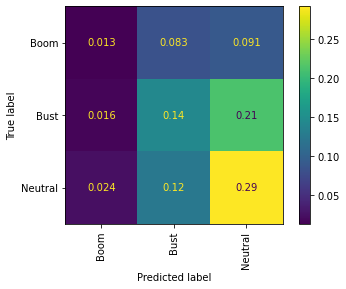

In [1028]:
plot_confusion_matrix(base_pipe_rf, X_test, y_test, xticks_rotation='vertical', normalize='all');

### Hyper Parameter Tuning

In [940]:
hyper_pipe_rf = imbPipeline([('trans', trans),
                     ('smote', SMOTE(random_state=42)),
                     ('RF', RandomForestClassifier(random_state=42))])

In [941]:
#Random Forest hyperparameters
min_samples_split = [4,6,8]
n_estimators = [1000]

#Create grid
rf_param_grid = [{'RF__min_samples_split': min_samples_split,
                   'RF__n_estimators': n_estimators}]

In [942]:
rf_grid_search = GridSearchCV(estimator=hyper_pipe_rf,
        param_grid=rf_param_grid,
        scoring='precision_macro',
        cv=2,
        n_jobs=-1)

In [943]:
hyper_grids = [rf_grid_search]

In [944]:
hyper_grid_dict = {0: 'Random Forest'}

In [945]:
start = time.time()

for pipe in hyper_grids:
    pipe.fit(X_train,y_train)
    
end = time.time()
print('Time it took to run the fittings: {}'.format(round(end-start),0) + ' seconds')

Time it took to run the fittings: 22 seconds


In [946]:
for i, model in enumerate(hyper_grids):
    print('{} Validation Accuracy: {}'.format(hyper_grid_dict[i], model.score(X_test,y_test)))
    print('{} Best Params: {}'.format(hyper_grid_dict[i], model.best_params_))

Random Forest Validation Accuracy: 0.3687448387277
Random Forest Best Params: {'RF__min_samples_split': 8, 'RF__n_estimators': 1000}


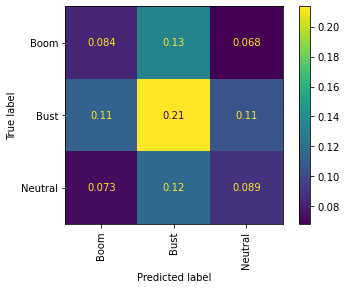

In [947]:
plot_confusion_matrix(rf_grid_search, X_test, y_test, xticks_rotation='vertical', normalize='all');

In [948]:
print(classification_report(y_test, rf_grid_search.predict(X_test)))

              precision    recall  f1-score   support

        Boom       0.31      0.29      0.30       338
        Bust       0.46      0.49      0.48       514
     Neutral       0.34      0.32      0.33       333

    accuracy                           0.39      1185
   macro avg       0.37      0.37      0.37      1185
weighted avg       0.38      0.39      0.38      1185



In [772]:
X_test['Prediction'] = rf_grid_search.predict(X_test)

<ipython-input-772-7ddcca51b91c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Prediction'] = rf_grid_search.predict(X_test)


In [773]:
X_test['True_Value'] = y_test

<ipython-input-773-ecae530174de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['True_Value'] = y_test


In [777]:
X_test[X_test['True_Value'] == 'bust']

,Name,Team,Week,Opponent,Points_Scored,Position,OPRNK,Projected,Salary,Games_Played,FPPG,Line Close,Total Score Close,Team Proj,Home / Away,Year,Prediction,True_Value
10423,John Brown,BAL,15,TB,1.40,WR,27.0,6.53,4800,14,9.0,-8.5,45.0,31.00,1.0,1.0,bust,bust
330,Doug Baldwin,SEA,1,GB,6.00,WR,32.0,13.87,7500,1,10.5,2.5,49.5,22.25,0.0,0.0,bust,bust
9800,Andrew Luck,IND,13,JAX,10.52,QB,16.0,20.31,8200,12,22.8,-4.0,45.5,26.75,0.0,1.0,bust,bust
2359,Andre Ellington,ARI,9,SF,2.40,RB,32.0,6.50,5100,6,6.6,-2.5,39.0,22.00,0.0,0.0,Neutral,bust
2507,Rob Gronkowski,NE,10,DEN,9.40,TE,31.0,14.12,8100,6,15.2,-7.0,45.0,29.50,0.0,0.0,bust,bust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2752,Cameron Brate,TB,10,NYJ,1.50,TE,28.0,8.48,5700,7,10.7,-1.0,44.5,23.25,1.0,0.0,Boom,bust
188,Dez Bryant,DAL,1,NYG,4.30,WR,7.0,13.00,7800,1,9.4,-6.0,46.5,29.25,1.0,0.0,bust,bust
10010,Marquez Valdes-Scantling,GB,14,ATL,2.90,WR,26.0,7.42,4900,13,6.0,-4.0,50.0,29.00,1.0,1.0,Neutral,bust
4387,Trevor Siemian,DEN,15,IND,1.68,QB,23.0,13.54,6000,9,15.0,-3.0,40.5,23.25,0.0,0.0,bust,bust
